<a href="https://colab.research.google.com/github/Caellwyn/ou_student_predictions/blob/deep_models/notebooks/deep_timeseries_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras

from seaborn import heatmap

from keras import Input
from keras import backend as K
from keras import regularizers, optimizers
from keras.layers import Dense, Dropout, Conv1D, \
AveragePooling1D, MaxPooling1D, LSTM, GRU, Flatten
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, \
roc_auc_score, plot_precision_recall_curve, plot_roc_curve, \
plot_confusion_matrix, confusion_matrix

from imblearn.over_sampling import SMOTENC

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

try:
    from src.functions import add_model, test_model, get_timeseries_table
except:
    from functions import add_model, test_model, get_timeseries_table

The below is thanks to [dokondr](https://stackoverflow.com/questions/45411902/how-to-use-f1-score-with-keras-model)

In [3]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [4]:
df = get_timeseries_table(prediction_window=135, 
                          binary_labels=True, 
                          one_hot_modules=True)
df

,assess_submitted_1,assess_score_1,assess_submitted_2,assess_score_2,assess_submitted_3,assess_score_3,assess_submitted_4,assess_score_4,assess_submitted_5,assess_score_5,assess_submitted_6,assess_score_6,assess_submitted_7,assess_score_7,assess_submitted_8,assess_score_8,sum_activities_-25,sum_click_-25,activities_x_clicks_-25,sum_activities_-24,sum_click_-24,activities_x_clicks_-24,sum_activities_-23,sum_click_-23,activities_x_clicks_-23,sum_activities_-22,sum_click_-22,activities_x_clicks_-22,sum_activities_-21,sum_click_-21,activities_x_clicks_-21,sum_activities_-20,sum_click_-20,activities_x_clicks_-20,sum_activities_-19,sum_click_-19,activities_x_clicks_-19,sum_activities_-18,sum_click_-18,activities_x_clicks_-18,...,sum_click_124,activities_x_clicks_124,sum_activities_125,sum_click_125,activities_x_clicks_125,sum_activities_126,sum_click_126,activities_x_clicks_126,sum_activities_127,sum_click_127,activities_x_clicks_127,sum_activities_128,sum_click_128,activities_x_clicks_128,sum_activities_129,sum_click_129,activities_x_clicks_129,sum_activities_130,sum_click_130,activities_x_clicks_130,sum_activities_131,sum_click_131,activities_x_clicks_131,sum_activities_132,sum_click_132,activities_x_clicks_132,sum_activities_133,sum_click_133,activities_x_clicks_133,sum_activities_134,sum_click_134,activities_x_clicks_134,final_result,module_AAA,module_BBB,module_CCC,module_DDD,module_EEE,module_FFF,module_GGG
registration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAA2013J11391,-1.0,78.0,-1.0,85.0,-2.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,13.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,42.0,210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0
AAA2013J28400,3.0,70.0,-2.0,68.0,4.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,23.0,253.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,38.0,418.0,0,1,0,0,0,0,0,0
AAA2013J31604,-2.0,72.0,-3.0,71.0,-2.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,10.0,51.0,510.0,0.0,0.0,0.0,6.0,19.0,114.0,5.0,16.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0
AAA2013J32885,7.0,69.0,21.0,30.0,7.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,162.0,5.0,8.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,9.0,18.0,2.0,9.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,0,1,0,0,0,0,0,0
AAA2013J38053,0.0,79.0,10.0,69.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,4.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,9.0,36.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGG2014J691787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1
GGG2014J692171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [5]:
X = df.drop(columns='final_result')
y = df['final_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111, test_size=.1)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111, test_size=.1)

categoricals = [502, 501, 500, 499, 498, 497, 496]
smotenc = SMOTENC(categoricals, random_state=111)
os_X_train, os_y_train = smotenc.fit_resample(X_train, y_train)
os_X_t, os_y_t = smotenc.fit_resample(X_t, y_t)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Epoch 1/50
98/98 [==============================] - 5s 13ms/step - loss: 14.8615 - accuracy: 0.6124 - val_loss: 13.8762 - val_accuracy: 0.6446
Epoch 2/50
98/98 [==============================] - 1s 7ms/step - loss: 13.6919 - accuracy: 0.6426 - val_loss: 13.2951 - val_accuracy: 0.6391
Epoch 3/50
98/98 [==============================] - 1s 7ms/step - loss: 13.1447 - accuracy: 0.6427 - val_loss: 12.8268 - val_accuracy: 0.6719
Epoch 4/50
98/98 [==============================] - 1s 6ms/step - loss: 12.6844 - accuracy: 0.6409 - val_loss: 12.3972 - val_accuracy: 0.6784
Epoch 5/50
98/98 [==============================] - 1s 7ms/step - loss: 12.2538 - accuracy: 0.6524 - val_loss: 11.9993 - val_accuracy: 0.5983
Epoch 6/50
98/98 [==============================] - 1s 7ms/step - loss: 11.8485 - accuracy: 0.6685 - val_loss: 11.5950 - val_accuracy: 0.5905
Epoch 7/50
98/98 [==============================] - 1s 7ms/step - loss: 11.4481 - accuracy: 0.6747 - val_loss: 11.1914 - val_accuracy: 0.5729
Epoch

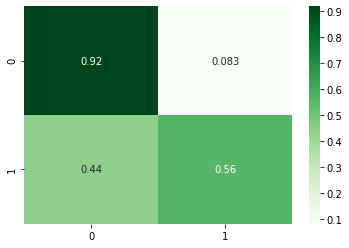

In [8]:
l1 = 1e-4
l2 = 1e-3
bias = 1e-4
dropout500=0.4
dropout300=0.2
dropout200=0.2

model1 = keras.Sequential()
model1.add(Input((X.shape[1])))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))

model1.add(Dense(1, activation='sigmoid'))

optimizer = optimizers.Adamax()

model1.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

#class_balance = num(pass) / num(fail).  Use this to weight class 0.
class_balance = sum(y_t == 1) / sum(y_t == 0)

model1.fit(X_t, y_t,
           batch_size = 200,
           epochs = 50,
           validation_data=(X_val, y_val),
        #    class_weight = {1: 1.0,
        #                    0: class_balance}
           )

yhat = np.around(model1.predict(X_val)).astype(int)[:,0]

confusion = confusion_matrix(y_val, yhat, normalize='true')
heatmap(confusion, cmap='Greens', annot=True)

Epoch 1/50
98/98 [==============================] - 3s 11ms/step - loss: 14.6885 - accuracy: 0.6125 - val_loss: 12.2887 - val_accuracy: 0.6391
Epoch 2/50
98/98 [==============================] - 1s 6ms/step - loss: 11.6966 - accuracy: 0.6386 - val_loss: 10.1294 - val_accuracy: 0.6858
Epoch 3/50
98/98 [==============================] - 1s 6ms/step - loss: 9.6047 - accuracy: 0.6800 - val_loss: 8.2058 - val_accuracy: 0.7210
Epoch 4/50
98/98 [==============================] - 1s 7ms/step - loss: 7.7759 - accuracy: 0.7317 - val_loss: 6.5753 - val_accuracy: 0.7483
Epoch 5/50
98/98 [==============================] - 1s 6ms/step - loss: 6.2198 - accuracy: 0.7652 - val_loss: 5.2493 - val_accuracy: 0.7733
Epoch 6/50
98/98 [==============================] - 1s 6ms/step - loss: 4.9693 - accuracy: 0.7728 - val_loss: 4.1943 - val_accuracy: 0.7765
Epoch 7/50
98/98 [==============================] - 1s 7ms/step - loss: 3.9725 - accuracy: 0.7792 - val_loss: 3.3620 - val_accuracy: 0.7848
Epoch 8/50
98/9

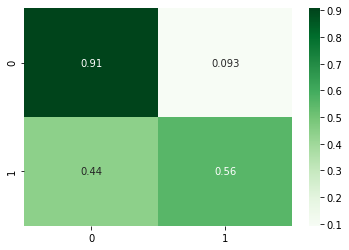

In [9]:
l1 = 1e-4
l2 = 1e-3
bias = 1e-4
dropout500=0.4
dropout300=0.2
dropout200=0.2

model1 = keras.Sequential()
model1.add(Input((X.shape[1])))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))

model1.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate = .001)

model1.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

class_balance = sum(y_t == 1) / sum(y_t == 0)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

model1.fit(X_t, y_t,
           batch_size = 200,
           epochs = 50,
           validation_data=(X_val, y_val),
           callbacks = [reduce_lr]
           )

#class_balance = num(pass) / num(fail).  Use this to weight class 0.
class_balance = sum(y_t == 1) / sum(y_t == 0)

model1.fit(X_t, y_t,
           batch_size = 200,
           epochs = 50,
           validation_data=(X_val, y_val),
        #    class_weight = {1: 1.0,
        #                    0: class_balance}
           )

yhat = np.around(model1.predict(X_val)).astype(int)[:,0]

confusion = confusion_matrix(y_val, yhat, normalize='true')
heatmap(confusion, cmap='Greens', annot=True)

In [ ]:
l1 = 1e-4
l2 = 1e-3
bias = 1e-4
dropout500=0.4
dropout300=0.2
dropout200=0.2

model1 = keras.Sequential()
model1.add(Input((X.shape[1])))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))

model1.add(Dense(1, activation='sigmoid'))

# optimizer = optimizers.SGD(learning_rate=.1)
optimizer = keras.optimizers.Adam(learning_rate = .001)

model1.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

class_balance = sum(y_t == 1) / sum(y_t == 0)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

model1.fit(os_X_t, os_y_t,
           batch_size = 200,
           epochs = 50,
           validation_data=(X_val, y_val),
           callbacks = [reduce_lr]
           )

yhat = np.around(model1.predict(X_val)).astype(int)[:,0]

confusion = confusion_matrix(y_val, yhat, normalize='true')

heatmap(confusion, cmap='Greens', annot=True)

In [47]:
conv_X_t = X_t.to_numpy().reshape(X_t.shape[0], X_t.shape[1], 1)
conv_X_val = X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1)


input_dims = (None , X_t.shape[1])
CNN_model = keras.Sequential()
CNN_model.add(Conv1D(filters=40, kernel_size=2, padding='causal', activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))

CNN_model.add(Dense(50, activation='relu'))
CNN_model.add(Dense(50, activation='relu'))
CNN_model.add(Dense(50, activation='relu'))
CNN_model.add(Dense(50, activation='relu'))

CNN_model.add(Dense(25, activation='relu'))
CNN_model.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate = .01)


CNN_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.fit(conv_X_t, y_t,
          epochs=50,
          validation_data=(conv_X_val, y_val),
          callbacks = reduce_lr)

yhat = np.around(CNN_model.predict(conv_X_val)).astype(int)[:,0]

confusion = confusion_matrix(y_val, yhat, normalize='true')

heatmap(confusion, cmap='Greens', annot=True)

Epoch 1/50
608/608 [==============================] - 4s 6ms/step - loss: 0.7120 - accuracy: 0.6392 - val_loss: 0.6383 - val_accuracy: 0.6391
Epoch 2/50
608/608 [==============================] - 3s 5ms/step - loss: 0.6360 - accuracy: 0.6393 - val_loss: 0.6376 - val_accuracy: 0.6391
Epoch 3/50
608/608 [==============================] - 3s 5ms/step - loss: 0.6322 - accuracy: 0.6452 - val_loss: 0.6375 - val_accuracy: 0.6391
Epoch 4/50
608/608 [==============================] - 3s 5ms/step - loss: 0.6363 - accuracy: 0.6375 - val_loss: 0.6376 - val_accuracy: 0.6391
Epoch 5/50
608/608 [==============================] - 3s 5ms/step - loss: 0.6332 - accuracy: 0.6427 - val_loss: 0.6388 - val_accuracy: 0.6391
Epoch 6/50
608/608 [==============================] - 3s 5ms/step - loss: 0.6339 - accuracy: 0.6403 - val_loss: 0.6390 - val_accuracy: 0.6391
Epoch 7/50
608/608 [==============================] - 3s 5ms/step - loss: 0.6351 - accuracy: 0.6376 - val_loss: 0.6413 - val_accuracy: 0.6391
Epoch 

KeyboardInterrupt: ignored

Epoch 1/50
195/195 [==============================] - 8s 30ms/step - loss: 0.6175 - accuracy: 0.6674 - val_loss: 0.5874 - val_accuracy: 0.7071
Epoch 2/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5613 - accuracy: 0.7232 - val_loss: 0.5423 - val_accuracy: 0.7380
Epoch 3/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5519 - accuracy: 0.7240 - val_loss: 0.6150 - val_accuracy: 0.6612
Epoch 4/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5976 - accuracy: 0.6836 - val_loss: 0.5987 - val_accuracy: 0.6935
Epoch 5/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5836 - accuracy: 0.7038 - val_loss: 0.5863 - val_accuracy: 0.7012
Epoch 6/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5735 - accuracy: 0.7117 - val_loss: 0.5992 - val_accuracy: 0.6860
Epoch 7/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5850 - accuracy: 0.6997 - val_loss: 0.5854 - val_accuracy: 0.7072

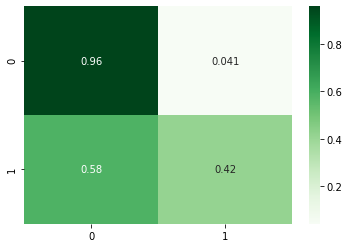

In [76]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=5)

conv_X_t = X_t.to_numpy().reshape(X_t.shape[0], X_t.shape[1], 1)
conv_X_val = X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1)

tf.executing_eagerly()

input_dims = (None , X_t.shape[1])
CNNLSTM_model = keras.Sequential()
CNNLSTM_model.add(Conv1D(filters=10, kernel_size=7, padding='valid', activation='relu'))
CNNLSTM_model.add(LSTM(25, activation='tanh', return_sequences=True, use_bias=True))
CNNLSTM_model.add(Dense(50, activation='relu'))
CNNLSTM_model.add(Dense(50, activation='relu'))
CNNLSTM_model.add(Dense(50, activation='relu'))
CNNLSTM_model.add(Dense(50, activation='relu'))
CNNLSTM_model.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate = .001)


CNNLSTM_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

CNNLSTM_model.fit(conv_X_t, y_t,
          epochs=50,
          batch_size=100,
          validation_data=(conv_X_val, y_val),
          callbacks = reduce_lr)

yhat = np.around(CNNLSTM_model.predict(conv_X_val)).astype(int)[:,0]

confusion = confusion_matrix(y_val, yhat, normalize='true')

heatmap(confusion, cmap='Greens', annot=True)

Epoch 1/50
195/195 [==============================] - 8s 30ms/step - loss: 0.6243 - accuracy: 0.6569 - val_loss: 0.5871 - val_accuracy: 0.7043
Epoch 2/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5809 - accuracy: 0.7089 - val_loss: 0.6300 - val_accuracy: 0.7315
Epoch 3/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5513 - accuracy: 0.7343 - val_loss: 0.5276 - val_accuracy: 0.7601
Epoch 4/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5337 - accuracy: 0.7463 - val_loss: 0.5322 - val_accuracy: 0.7448
Epoch 5/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5184 - accuracy: 0.7619 - val_loss: 0.5302 - val_accuracy: 0.7531
Epoch 6/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5777 - accuracy: 0.7263 - val_loss: 0.5677 - val_accuracy: 0.7072
Epoch 7/50
195/195 [==============================] - 5s 28ms/step - loss: 0.5402 - accuracy: 0.7351 - val_loss: 0.5197 - val_accuracy: 0.7700

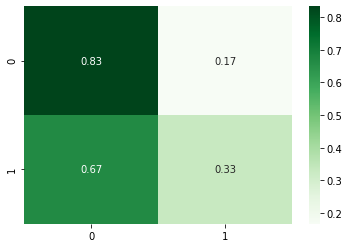

In [77]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=5)

conv_X_t = X_t.to_numpy().reshape(X_t.shape[0], X_t.shape[1], 1)
conv_X_val = X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1)

tf.executing_eagerly()

input_dims = (None , X_t.shape[1])
LSTM_model = keras.Sequential()
LSTM_model.add(LSTM(25, activation='tanh', return_sequences=True, use_bias=True))
LSTM_model.add(Dense(50, activation='relu'))
LSTM_model.add(Dense(50, activation='relu'))
LSTM_model.add(Dense(50, activation='relu'))
LSTM_model.add(Dense(50, activation='relu'))
LSTM_model.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate = .001)


LSTM_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.fit(conv_X_t, y_t,
          epochs=50,
          batch_size=100,
          validation_data=(conv_X_val, y_val),
          callbacks = reduce_lr)

yhat = np.around(LSTM_model.predict(conv_X_val)).astype(int)[:,0]

confusion = confusion_matrix(y_val, yhat, normalize='true')

heatmap(confusion, cmap='Greens', annot=True)

Epoch 1/100
2489/2489 [==============================] - 20s 7ms/step - loss: 23.4419 - accuracy: 0.6202 - val_loss: 0.9539 - val_accuracy: 0.7325
Epoch 2/100
2489/2489 [==============================] - 16s 6ms/step - loss: 0.8555 - accuracy: 0.7168 - val_loss: 0.7627 - val_accuracy: 0.7395
Epoch 3/100
2489/2489 [==============================] - 16s 6ms/step - loss: 0.7907 - accuracy: 0.7196 - val_loss: 0.7723 - val_accuracy: 0.7566
Epoch 4/100
2489/2489 [==============================] - 16s 7ms/step - loss: 0.8032 - accuracy: 0.7193 - val_loss: 0.8746 - val_accuracy: 0.6557
Epoch 5/100
2489/2489 [==============================] - 16s 6ms/step - loss: 0.8091 - accuracy: 0.7185 - val_loss: 0.7510 - val_accuracy: 0.7612
Epoch 6/100
2489/2489 [==============================] - 16s 7ms/step - loss: 0.8040 - accuracy: 0.7231 - val_loss: 0.9169 - val_accuracy: 0.6104
Epoch 7/100
2489/2489 [==============================] - 16s 6ms/step - loss: 0.8019 - accuracy: 0.7174 - val_loss: 0.7441 

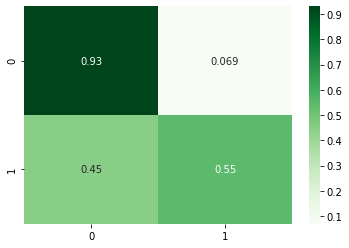

In [91]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=5)

l1 = 1e-4
l2 = 1e-2
bias = 1e-4
dropout500=0.4
dropout300=0.3
dropout200=0.3

model1 = keras.Sequential()
model1.add(Input((X.shape[1])))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(500, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout500))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(300, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout300))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))
model1.add(Dropout(rate=dropout200))
model1.add(Dense(200, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                 bias_regularizer=regularizers.l2(bias)))

model1.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate = .001)


model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model1.fit(os_X_t, os_y_t,
          epochs=100,
          batch_size=10,
          validation_data=(X_val, y_val),
          callbacks = reduce_lr)

yhat = np.around(model1.predict(X_val)).astype(int)[:,0]

confusion = confusion_matrix(y_val, yhat, normalize='true')
heatmap(confusion, cmap='Greens', annot=True)

In [92]:
y_t

registration
DDD2013J59370      0
CCC2014J655973     0
BBB2013J563794     0
DDD2013B2536214    1
BBB2014B607953     1
                  ..
FFF2013B494165     0
FFF2013B536455     0
BBB2014B625249     0
BBB2014J692175     1
BBB2013J486457     0
Name: final_result, Length: 19443, dtype: int64

In [101]:
df2 = get_timeseries_table(prediction_window=135)

assessments merged:  1


In [104]:
yhat = np.around(model1.predict(X_val)).astype(int)[:,0]
error = pd.DataFrame(y_val.copy())
error['pred_result'] = yhat
error = error.merge(df2[['final_result']], on='registration', how='left')
error[error['final_result_x'] != error['pred_result']]['final_result_y'].value_counts()

Fail           259
Withdrawn       93
Pass            88
Distinction      7
Name: final_result_y, dtype: int64

In [105]:
error['final_result_y'].value_counts()

Pass           1138
Fail            580
Distinction     243
Withdrawn       200
Name: final_result_y, dtype: int64

In [106]:
analysis = pd.DataFrame()
analysis['error'] = error[error['final_result_x'] != error['pred_result']]['final_result_y'].value_counts()
analysis['total'] = error['final_result_y'].value_counts()
analysis

,error,total
Fail,259,580
Withdrawn,93,200
Pass,88,1138
Distinction,7,243


In [107]:
analysis['error'] = analysis['error']/analysis['error'].sum()
analysis['total'] = analysis['total']/analysis['total'].sum()
analysis

,error,total
Fail,0.579418,0.268394
Withdrawn,0.208054,0.092550
Pass,0.196868,0.526608
Distinction,0.015660,0.112448


In [108]:
analysis['ratio'] = analysis['error']/analysis['total']

In [109]:
analysis

,error,total,ratio
Fail,0.579418,0.268394,2.158833
Withdrawn,0.208054,0.092550,2.248020
Pass,0.196868,0.526608,0.373842
Distinction,0.015660,0.112448,0.139264
